In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part4_superposition_and_saes"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
)


device = t.device("cuda" if t.cuda.is_available() else "cpu")


In [2]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


In [3]:
@dataclass
class AutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    l1_coeff: float = 0.5
    tied_weights: bool = False
    weight_normalize_eps: float = 1e-8


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: AutoEncoderConfig):
        super(AutoEncoder, self).__init__()
        self.cfg = cfg

        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))

        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))

        self.to(device)

    def normalize_and_return_W_dec(self) -> Float[Tensor, "n_instances n_hidden_ae n_input_ae"]:
        '''
        If self.cfg.tied_weights = True, we return the normalized & transposed encoder weights.
        If self.cfg.tied_weights = False, we normalize the decoder weights in-place, and return them.

        Normalization should be over the `n_input_ae` dimension, i.e. each feature should have a noramlized decoder weight.
        '''
        if self.cfg.tied_weights:
            return self.W_enc.transpose(-1, -2) / (self.W_enc.transpose(-1, -2).norm(dim=1, keepdim=True) + self.cfg.weight_normalize_eps)
        else:
            self.W_dec.data = self.W_dec.data / (self.W_dec.data.norm(dim=2, keepdim=True) + self.cfg.weight_normalize_eps)
            return self.W_dec

            


    def forward(self, h: Float[Tensor, "batch_size n_instances n_input_ae"]):
        '''
        Runs a forward pass on the autoencoder, and returns several outputs.

        Inputs:
            h: Float[Tensor, "batch_size n_instances n_input_ae"]
                hidden activations generated from a Model instance

        Returns:
            l1_loss: Float[Tensor, "batch_size n_instances"]
                L1 loss for each batch elem & each instance (sum over the `n_hidden_ae` dimension)
            l2_loss: Float[Tensor, "batch_size n_instances"]
                L2 loss for each batch elem & each instance (take mean over the `n_input_ae` dimension)
            loss: Float[Tensor, ""]
                Sum of L1 and L2 loss (with the former scaled by `self.cfg.l1_coeff). We sum over the `n_instances`
                dimension but take mean over the batch dimension
            acts: Float[Tensor, "batch_size n_instances n_hidden_ae"]
                Activations of the autoencoder's hidden states (post-ReLU)
            h_reconstructed: Float[Tensor, "batch_size n_instances n_input_ae"]
                Reconstructed hidden states, i.e. the autoencoder's final output
        '''
        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, self.normalize_and_return_W_dec(),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).mean(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum() # scalar

        return l1_loss, l2_loss, loss, acts, h_reconstructed

    def optimize(
        self,
        model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        The autoencoder is trained on the hidden state activations produced by 'model', and it
        learns to reconstruct the features which this model represents in superposition.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"W_enc": [], "W_dec": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model (for the training step, and the neuron resampling)
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "batch instances feats, instances hidden feats -> batch instances hidden")

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Apply resampling
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Optimize
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate the mean sparsities over batch dim for each (instance, feature)
            frac_active = (acts.abs() > 1e-8).float().mean(0)
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["W_enc"].append(self.W_enc.detach().cpu().clone())
                data_log["W_dec"].append(self.normalize_and_return_W_dec().detach().cpu().clone())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu().clone())

        return data_log


    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_input_ae"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> Tuple[List[List[str]], str]:
        '''
        Resamples neurons that have been dead for 'dead_feature_window' steps, according to `frac_active`.

        Resampling method is:
            - Compute L2 loss for each element in the batch
            - For each dead neuron, sample activations from `h` with probability proportional to squared reconstruction loss
            - Set new values of W_dec, W_enc and b_enc at all dead neurons, based on these resamplings:
                - W_dec should be the normalized sampled values of `h`
                - W_enc should be the sampled values of `h`, with norm equal to the average norm of alive encoder weights
                - b_enc should be zero

        Returns colors and titles (useful for creating the animation: resampled neurons appear in red).
        '''
        l2_loss = self.forward(h)[1]

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_features_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_features_mask[instance] = is_dead
            dead_features = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_features.numel()
            if n_dead == 0: continue

            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance] # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue # If we have zero reconstruction loss, we don't need to resample neurons

            # Draw `n_hidden_ae` samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance.pow(2) / l2_loss_instance.pow(2).sum())
            replacement_indices = distn.sample((n_dead,)) # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance] # shape [n_dead n_input_ae]
            replacement_values_normalized = replacement_values / (replacement_values.norm(dim=-1, keepdim=True) + 1e-8)

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()

            # Lastly, set the new weights & biases
            # For W_dec (the dictionary vectors), we just use the normalized replacement values
            self.W_dec.data[instance, dead_features, :] = replacement_values_normalized
            # For W_enc (the encoder vectors), we use the normalized replacement values scaled by (mean alive neuron norm * neuron resample scale)
            self.W_enc.data[instance, :, dead_features] = replacement_values_normalized.T * W_enc_norm_alive_mean * neuron_resample_scale
            # For b_enc (the encoder bias), we set it to zero
            self.b_enc.data[instance, dead_features] = 0.0

        # Return data for visualising the resampling process
        colors = [["red" if dead else "black" for dead in dead_feature_mask_inst] for dead_feature_mask_inst in dead_features_mask]
        title = f"resampling {dead_features_mask.sum()}/{dead_features_mask.numel()} neurons (shown in red)"
        return colors, title

In [5]:
cfg = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)
model = Model(
    cfg = cfg,
    device = device,
    feature_probability = 0.01,
)
model.optimize(steps=10_000)

NameError: name 'Config' is not defined

In [4]:
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.25,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 20_000,
    neuron_resample_window = 2_500,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 200,
)

# We'll be plotting encoder & decoder on the first & second rows
titles = [title + ", first row = encoder, second row = decoder" for title in data_log["titles"]]

# Stack encoder and decoder along the n_instances dimension
data = t.concat([
    t.stack(data_log["W_enc"], dim=0),
    t.stack(data_log["W_dec"], dim=0).transpose(-1, -2)
], dim=1)

NameError: name 'model' is not defined

In [ ]:
plot_features_in_2d(
    data,
    colors = data_log["colors"],
    title = titles,
    colab = True,
    n_rows = 2,
)

frac_active_line_plot(
    frac_active = t.stack(data_log["frac_active"], dim=0),
    feature_probability = 0.01,
    y_max = 0.05,
    title = "Probability of autoencoder neurons being active during training",
    width = 1000,
)

In [10]:
from transformer_lens import HookedTransformer, FactoredMatrix
from transformer_lens.hook_points import HookPoint

from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

In [11]:
VERSION_DICT = {"run1": 25, "run2": 47}

def load_autoencoder_from_huggingface(versions: List[str] = ["run1", "run2"]):
    state_dict = {}

    for version in versions:
        version_id = VERSION_DICT[version]
        # Load the data from huggingface (both metadata and state dict)
        sae_data: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}_cfg.json")
        new_state_dict: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}.pt", force_is_torch=True)
        # Add new state dict to the existing one
        for k, v in new_state_dict.items():
            state_dict[k] = t.stack([state_dict[k], v]) if k in state_dict else v

    # Get data about the model dimensions, and use that to initialize our model (with 2 instances)
    d_mlp = sae_data["d_mlp"]
    dict_mult = sae_data["dict_mult"]
    n_hidden_ae = d_mlp * dict_mult

    cfg = AutoEncoderConfig(
        n_instances = 2,
        n_input_ae = d_mlp,
        n_hidden_ae = n_hidden_ae,
    )

    # Initialize our model, and load in state dict
    autoencoder = AutoEncoder(cfg)
    autoencoder.load_state_dict(state_dict)

    return autoencoder


autoencoder = load_autoencoder_from_huggingface()

In [12]:
model = HookedTransformer.from_pretrained("gelu-1l").to(device)

print(model)

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cpu
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
 

In [13]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]
print("Tokens shape: ", all_tokens.shape)

Tokens shape:  torch.Size([215402, 128])


In [14]:
batch = all_tokens[:12].to(device)
logits, cache = model.run_with_cache(batch)
hidden_states = cache['blocks.0.mlp.hook_post']
formatted_hidden_states = einops.repeat(hidden_states, "batch seq hidden -> (batch seq) n_instances hidden", n_instances=autoencoder.cfg.n_instances)

In [15]:
l1_loss, l2_loss, loss, acts, h_reconstructed = autoencoder(formatted_hidden_states)

In [16]:
activated = acts.abs() > 1e-8
frac_active = activated.float().mean(0)

In [17]:
frac_active

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0026, 0.0013, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0052, 0.0000, 0.0000]])

In [18]:
formatted_hidden_states = einops.repeat(hidden_states, "batch seq hidden -> (batch seq) hidden n_instances", n_instances=autoencoder.cfg.n_instances)

In [19]:
formatted_hidden_states.shape

torch.Size([1536, 2048, 2])

In [20]:
@t.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, "instance n_hidden_ae"]:
    '''
    Returns the feature probabilities (i.e. fraction of time the feature is active) for each feature in the
    autoencoder, averaged over all `batch * seq` tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)

    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert post_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    acts = autoencoder.forward(post_reshaped)[3]
    assert acts.shape == (batch_size * seq_len, 2, autoencoder.cfg.n_hidden_ae)

    return acts.mean(0)

    


# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i:i+50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

# Visualise sparsities for each instance
for i, lf in enumerate(log_freq):
    hist(
        lf,
        title=f"Instance #{i+1}: Log Frequency of Features",
        labels={"x": "log<sub>10</sub>(freq)"},
        histnorm="percent",
        template="ggplot2"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
@t.no_grad()
def get_acts(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, "instance n_hidden_ae"]:
    '''
    Returns the feature probabilities (i.e. fraction of time the feature is active) for each feature in the
    autoencoder, averaged over all `batch * seq` tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)

    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert post_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    acts = autoencoder.forward(post_reshaped)[3]
    assert acts.shape == (batch_size * seq_len, 2, autoencoder.cfg.n_hidden_ae)

    return acts

@t.no_grad()
def get_residuals(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, "batch seq d_mlp"]:
    '''
    Returns the residuals (i.e. difference between the original hidden states and the reconstructed hidden states)
    for each token in the batch.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)

    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert post_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    _, _, _, _, h_reconstructed = autoencoder.forward(post_reshaped)
    residuals = post_reshaped - h_reconstructed
    assert residuals.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    return residuals

sample_tokens = all_tokens[:100]
acts = get_acts(sample_tokens, model, autoencoder)

residuls = get_residuals(sample_tokens, model, autoencoder)

In [45]:
acts.shape

torch.Size([12800, 2, 16384])

In [46]:
residuls.shape

torch.Size([12800, 2, 2048])

In [22]:
num_feature_per_point = acts.sum(2)

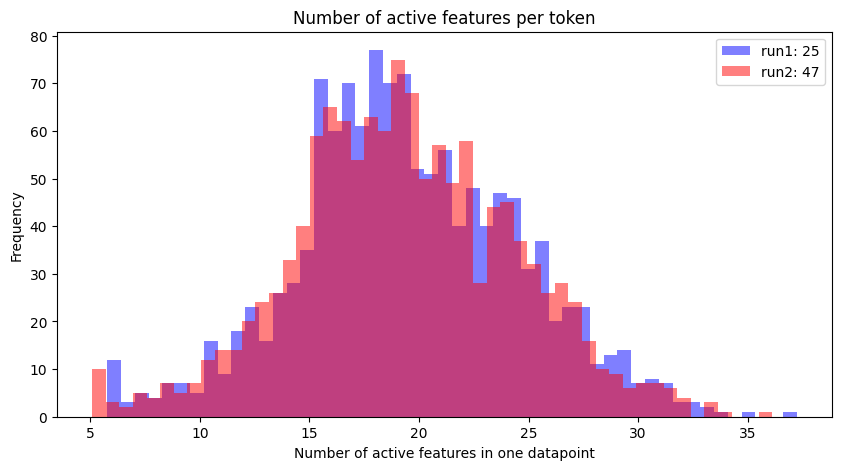

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(num_feature_per_point[:,0], bins=50, color="blue", alpha=0.5, label="run1: 25")
plt.hist(num_feature_per_point[:,1], bins=50, color="red", alpha=0.5, label="run2: 47")
plt.title("Number of active features per token")
plt.xlabel("Number of active features in one datapoint")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [32]:
# make 2 histograms, one for each instance
for i in range(2):
    hist(
        num_feature_per_point[:, i],
        title=f"Number of Active Features for Instance {i+1}",
        labels={"x": "Number of Active Features"},
        template="ggplot2",
        nbins = 37

    )

In [79]:
# Get all the rare features
is_rare = feature_probability[0] < 1e-4
rare_encoder_directions = autoencoder.W_enc[0, :, is_rare]
rare_encoder_directions_normalized = rare_encoder_directions / rare_encoder_directions.norm(dim=0, keepdim=True)

# Compute their pairwise cosine similarities & sample randomly from this N*N matrix of similarities
cos_sims_rare = (rare_encoder_directions_normalized.T @ rare_encoder_directions_normalized).flatten()
cos_sims_rare_random_sample = cos_sims_rare[t.randint(0, cos_sims_rare.shape[0], (10000,))]

# Plot results
hist(
    cos_sims_rare_random_sample,
    marginal="box",
    title="Cosine similarities of random rare encoder directions with each other",
    labels={"x": "Cosine sim"},
    histnorm="percent",
    template="ggplot2"
)

In [94]:
@t.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[float, float]:
    '''
    Returns the reconstruction loss of each autoencoder instance on the given batch of tokens (i.e.
    the L2 loss between the activations and the autoencoder's reconstructions, averaged over all tokens).
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)

    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert post_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    _, l2_loss, _, _, post_reconstructed = autoencoder.forward(post_reshaped)
    assert l2_loss.shape == (batch_size * seq_len, 2) # shape is [datapoints n_instances=2]
    assert post_reconstructed.shape == (batch_size * seq_len, 2, model.cfg.d_mlp) # shape is [datapoints n_instances=2 d_mlp]

    # Print out the avg L2 norm of activations
    print("Avg L2 norm of acts: ", einops.reduce(post_reshaped.pow(2), "batch inst d_mlp -> inst", "mean").tolist())
    # Print out the cosine similarity between original neuron activations & reconstructions (averaged over neurons)
    print("Avg cos sim of neuron reconstructions: ", t.cosine_similarity(post_reconstructed, post_reshaped, dim=0).mean(-1).tolist())

    return l2_loss.mean(0).tolist()

reconstruction_loss = get_reconstruction_loss(all_tokens[:10], model, autoencoder)
print(reconstruction_loss)

Avg L2 norm of acts:  [0.11062069982290268, 0.11062069982290268]
Avg cos sim of neuron reconstructions:  [0.834820032119751, 0.8347105383872986]
[0.043452925980091095, 0.04341978207230568]


In [96]:
@t.no_grad()
def get_substitution_loss(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Tuple[float, float, float, float]:
    '''
    Returns the substitution loss of the autoencoder on the given batch of tokens: in other words, the
    model's cross entropy loss subject to replacing the transformer's neuron activations with the 
    autoencoder's reconstructed activations, or zero-ablating them.

    We do this in 4 different forward passes: one `run_with_cache` to get the activation, and then 3
    separate patched forward passes.
    '''
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run (and get the clean loss)
    loss_clean, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"], return_type="loss")
    post = cache["blocks.0.mlp.hook_post"]
    post_reshaped = einops.repeat(post, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)

    # Use these to get 'post_reconstructed' (for both autoencoder A and B). We need to reshape back to (batch, seq) first
    post_reconstructed = autoencoder.forward(post_reshaped)[-1]
    post_reconstructed_A, post_reconstructed_B = einops.rearrange(
        post_reconstructed,
        "(batch seq) instance d_mlp -> instance batch seq d_mlp",
        batch = batch_size
    )

    # Define hook fn to replace activations with different values
    def hook_function(activations: Float[Tensor, "triple_batch seq d_mlp"], hook: HookPoint, new_activations):
        activations[:] = new_activations
        return activations

    # Run the hook function in 3 different cases: autoencoder A's reconstructions, B's reconstructions, and zero-ablation
    loss_reconstructed_A = model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[("blocks.0.mlp.hook_post", partial(hook_function, new_activations=post_reconstructed_A))],
    )
    loss_reconstructed_B = model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[("blocks.0.mlp.hook_post", partial(hook_function, new_activations=post_reconstructed_B))],
    )
    loss_zero_ablation = model.run_with_hooks(
        tokens,
        return_type="loss",
        fwd_hooks=[("blocks.0.mlp.hook_post", partial(hook_function, new_activations=0.0))],
    )

    return loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation

In [97]:
loss_clean, loss_reconstructed_A, loss_reconstructed_B, loss_zero_ablation = get_substitution_loss(all_tokens[:5], model, autoencoder)

score_A = ((loss_zero_ablation - loss_reconstructed_A)/(loss_zero_ablation - loss_clean))
score_B = ((loss_zero_ablation - loss_reconstructed_B)/(loss_zero_ablation - loss_clean))

print(f"Reconstruction Score A: {score_A:.2%}")
print(f"Reconstruction Score B: {score_B:.2%}")

Reconstruction Score A: 76.52%
Reconstruction Score B: 76.10%


In [98]:
print(f"loss clean: {loss_clean}")
print(f"loss reconstructed A: {loss_reconstructed_A}")
print(f"loss reconstructed B: {loss_reconstructed_B}")
print(f"loss zero ablation: {loss_zero_ablation}")

loss clean: 3.4580342769622803
loss reconstructed A: 4.783257961273193
loss reconstructed B: 4.806926250457764
loss zero ablation: 9.101017951965332
